<a href="https://colab.research.google.com/github/MorgooN/ML-Labs/blob/main/LAB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from keras import Model, Input
from keras.callbacks import ModelCheckpoint
from keras import Sequential, layers

In [2]:
batch_size = 32

# image size
img_height = 256
img_width = 256

In [3]:
!gdown --id 1B-OdkkVOTLx8k5iERDOG8z4wUfIhsBYr # downloading saved dataset from google drive

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1B-OdkkVOTLx8k5iERDOG8z4wUfIhsBYr
To: /content/archiveFaces.zip
100% 614M/614M [00:10<00:00, 61.2MB/s]


In [4]:
!unzip archiveFaces.zip # unpack zip files

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/unsavory/1223.jpg  
  inflating: train/unsavory/1224.jpg  
  inflating: train/unsavory/1225.jpg  
  inflating: train/unsavory/1226.jpg  
  inflating: train/unsavory/1227.jpg  
  inflating: train/unsavory/1228.jpg  
  inflating: train/unsavory/1229.jpg  
  inflating: train/unsavory/1230.jpg  
  inflating: train/unsavory/1231.jpg  
  inflating: train/unsavory/1232.jpg  
  inflating: train/unsavory/1233.jpg  
  inflating: train/unsavory/1234.jpg  
  inflating: train/unsavory/1235.jpg  
  inflating: train/unsavory/1236.jpg  
  inflating: train/unsavory/1237.jpg  
  inflating: train/unsavory/1238.jpg  
  inflating: train/unsavory/1239.jpg  
  inflating: train/unsavory/1240.jpg  
  inflating: train/unsavory/1241.jpg  
  inflating: train/unsavory/1242.jpg  
  inflating: train/unsavory/1243.jpg  
  inflating: train/unsavory/1244.jpg  
  inflating: train/unsavory/1245.jpg  
  inflating: train/unsavory/1246.jp

In [5]:
train_ds = keras.utils.image_dataset_from_directory(
  directory= "/content/train", # path to test data
  label_mode = 'int',       # correct answers as numbers(Label Encoding): 0, 1, 2, 3 etc.
  color_mode='rgb',         # each image as RGB
  batch_size=batch_size,    # batch-size regulator
  seed=123,
  image_size=(img_height, img_width),
  shuffle=True)

Found 11220 files belonging to 2 classes.


In [6]:
val_ds = keras.utils.image_dataset_from_directory(
  directory= "/content/valid",  # path to val. data
  label_mode = 'int',
  color_mode='rgb',
  batch_size=batch_size,
  seed=123,
  image_size=(img_height, img_width),
  shuffle=False) # disable shuffle for a val. data

Found 600 files belonging to 2 classes.


In [7]:

test_ds = keras.utils.image_dataset_from_directory(
    directory= "/content/test",  # path to test. data
    label_mode = 'int',
    color_mode='rgb',
    batch_size=batch_size,
    seed=123,
    image_size=(img_height, img_width),
    shuffle=False) # also disable shuffle for a test. data

# minmax normalization for a dataset will perform automatically
normalization_layer = Rescaling(1./255)
normalized_ds1 = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_ds2 = val_ds.map(lambda x, y: (normalization_layer(x), y))
#normalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 600 files belonging to 2 classes.


In [8]:
class_names = train_ds.class_names # список классов
num_classes = len(class_names) # количество классов, чтобы указать их в последнем выходном слое

In [9]:
def createModel(input_shape):
  input_layer = Input(shape=input_shape) # input layer

  # 1 st convolutional layer
  conv_1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same') (input_layer)
  pool_1 = MaxPooling2D(2, 2) (conv_1)

  # 2 nd layer
  conv_2 = Conv2D(64, (3, 3), activation='relu', padding='same') (pool_1)
  pool_2 = MaxPooling2D(2, 2) (conv_2)

  # 3 rd layer
  conv_3 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool_2)
  pool_3 = MaxPooling2D(2, 2) (conv_3)

  # 4 th layer
  conv_4 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool_3)

  pool_4 = MaxPooling2D(2, 2) (conv_4)
  # 5 th layer which did not improve our metrics
  #conv_5 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool_3)
  #pool_5 = MaxPooling2D(2, 2) (conv_4)

  ## In general, we have 4-5 convolutional blocks (conv+pool layer)




  # flatten_features = Flatten() (pool_4)
  # ffn = Dense(256, activation='relu') (flatten_features)
  # output = Dense(num_classes, activation='softmax') (ffn)

  # Global Average Pooling
  averaged_features = GlobalAveragePooling2D()(pool_4)
  flatten_features = Flatten() (averaged_features)
  output = Dense(num_classes, activation='softmax') (flatten_features)

  return Model(inputs=input_layer, outputs=output)

In [10]:
def trainModel(train_dataset, val_dataset):
  save_callback = ModelCheckpoint(filepath='best_model.h5',
                                  monitor = 'val_loss',
                                  save_best_only = True,
                                  save_weights_only=True,
                                  mode = 'min',
                                  verbose=1)

  model = createModel((img_height, img_width, 3))
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics='accuracy')

  model.summary()
  model.fit(train_dataset,
            validation_data=val_dataset,
            epochs=30,
            callbacks=[save_callback]
            )
  return model

In [11]:
model = trainModel(train_ds, val_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

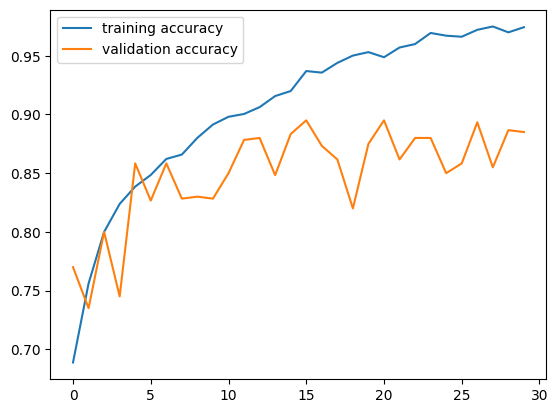

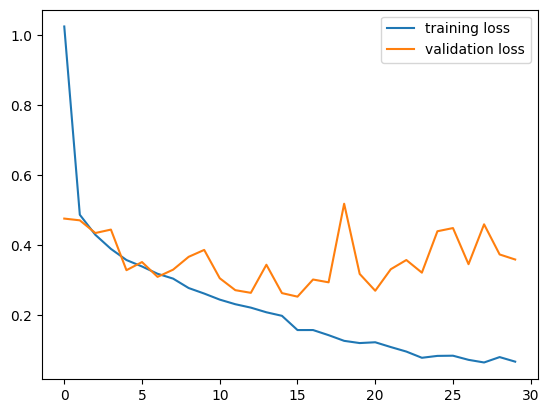

In [12]:
# graphs for a training parameters: accuracy and loss
plt.figure()
plt.plot(model.history.history["accuracy"], label="training accuracy")
plt.plot(model.history.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

In [13]:
loss, accuracy = model.evaluate(test_ds)

19/19 [==============================] - 1s 69ms/step - loss: 0.2072 - accuracy: 0.9400


1/1 [==============================] - 0s 328ms/step
Предсказанный ответ: savory
Правильный ответ: savory


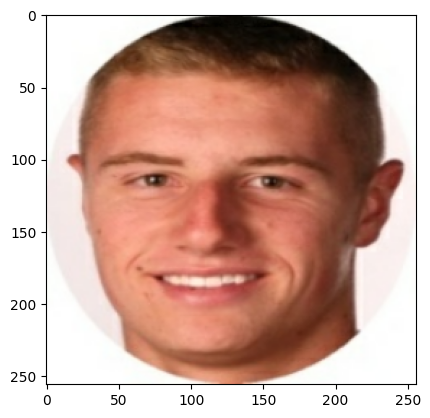

In [14]:
     file = r'D:\Git\ML-Labs\LAB_2_Images\dataTraining.png'
    test_im = cv2.imread(file,cv2.IMREAD_GRAYSCALE)

    # Format image
    img_resized = cv2.resize(test_im, (28,28), interpolation=cv2.INTER_LINEAR)
    # Get the predicted class label
    predicted_class_index = tf.argmax(predictions, axis=-1)
    predicted_class_label = test_ds.class_names[predicted_class_index[0]]
    # Print the predicted class label and true label
    print("Предсказанный ответ:", predicted_class_label)
    print("Правильный ответ:", test_ds.class_names[label])
    plt.imshow(image.numpy().astype("uint8"))